In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

## Muograms

In [2]:
def get_data(path):
    data_list = sorted(os.listdir(path)) # Data names list
    data = np.array([np.loadtxt(path+'/'+data, comments = '#') for data in data_list]) # Read data
    return data, data_list

In [3]:
path = '/home/kevin/Documentos/muograms3'
data, data_list = get_data(path)
print(data.shape)

(42, 100, 100)


In [4]:
cenit = np.linspace(-8, 20,100)
azimut = np.linspace(-50,50,100)

In [5]:
def plot_muograms(muograms,cenit,azimut,data_list,nrows,ncols,save=False,axis=True):
    plt.figure(figsize=(ncols*7,nrows*5))
    plt.rcParams.update({'font.size': 12})
    for i in range(len(muograms)):
        plt.subplot(nrows,ncols,i+1)
        plt.imshow(muograms[i],cmap='jet')
        plt.xticks(range(muograms.shape[2])[::20],np.round(np.unique(azimut)[::20],2))
        plt.xlabel(r'$\Theta_x$ [degree]')
        plt.yticks(range(muograms.shape[1])[::20],np.round(np.unique(cenit)[::20],2))
        plt.ylabel(r'$\Theta_y$ [degree]')
        if not axis:
            plt.axis('off')
        plt.colorbar(shrink=0.9,label='D [m]')
        #plt.title(data_list[i])
    if save:
        plt.savefig('CMmuograms.svg',format='svg')

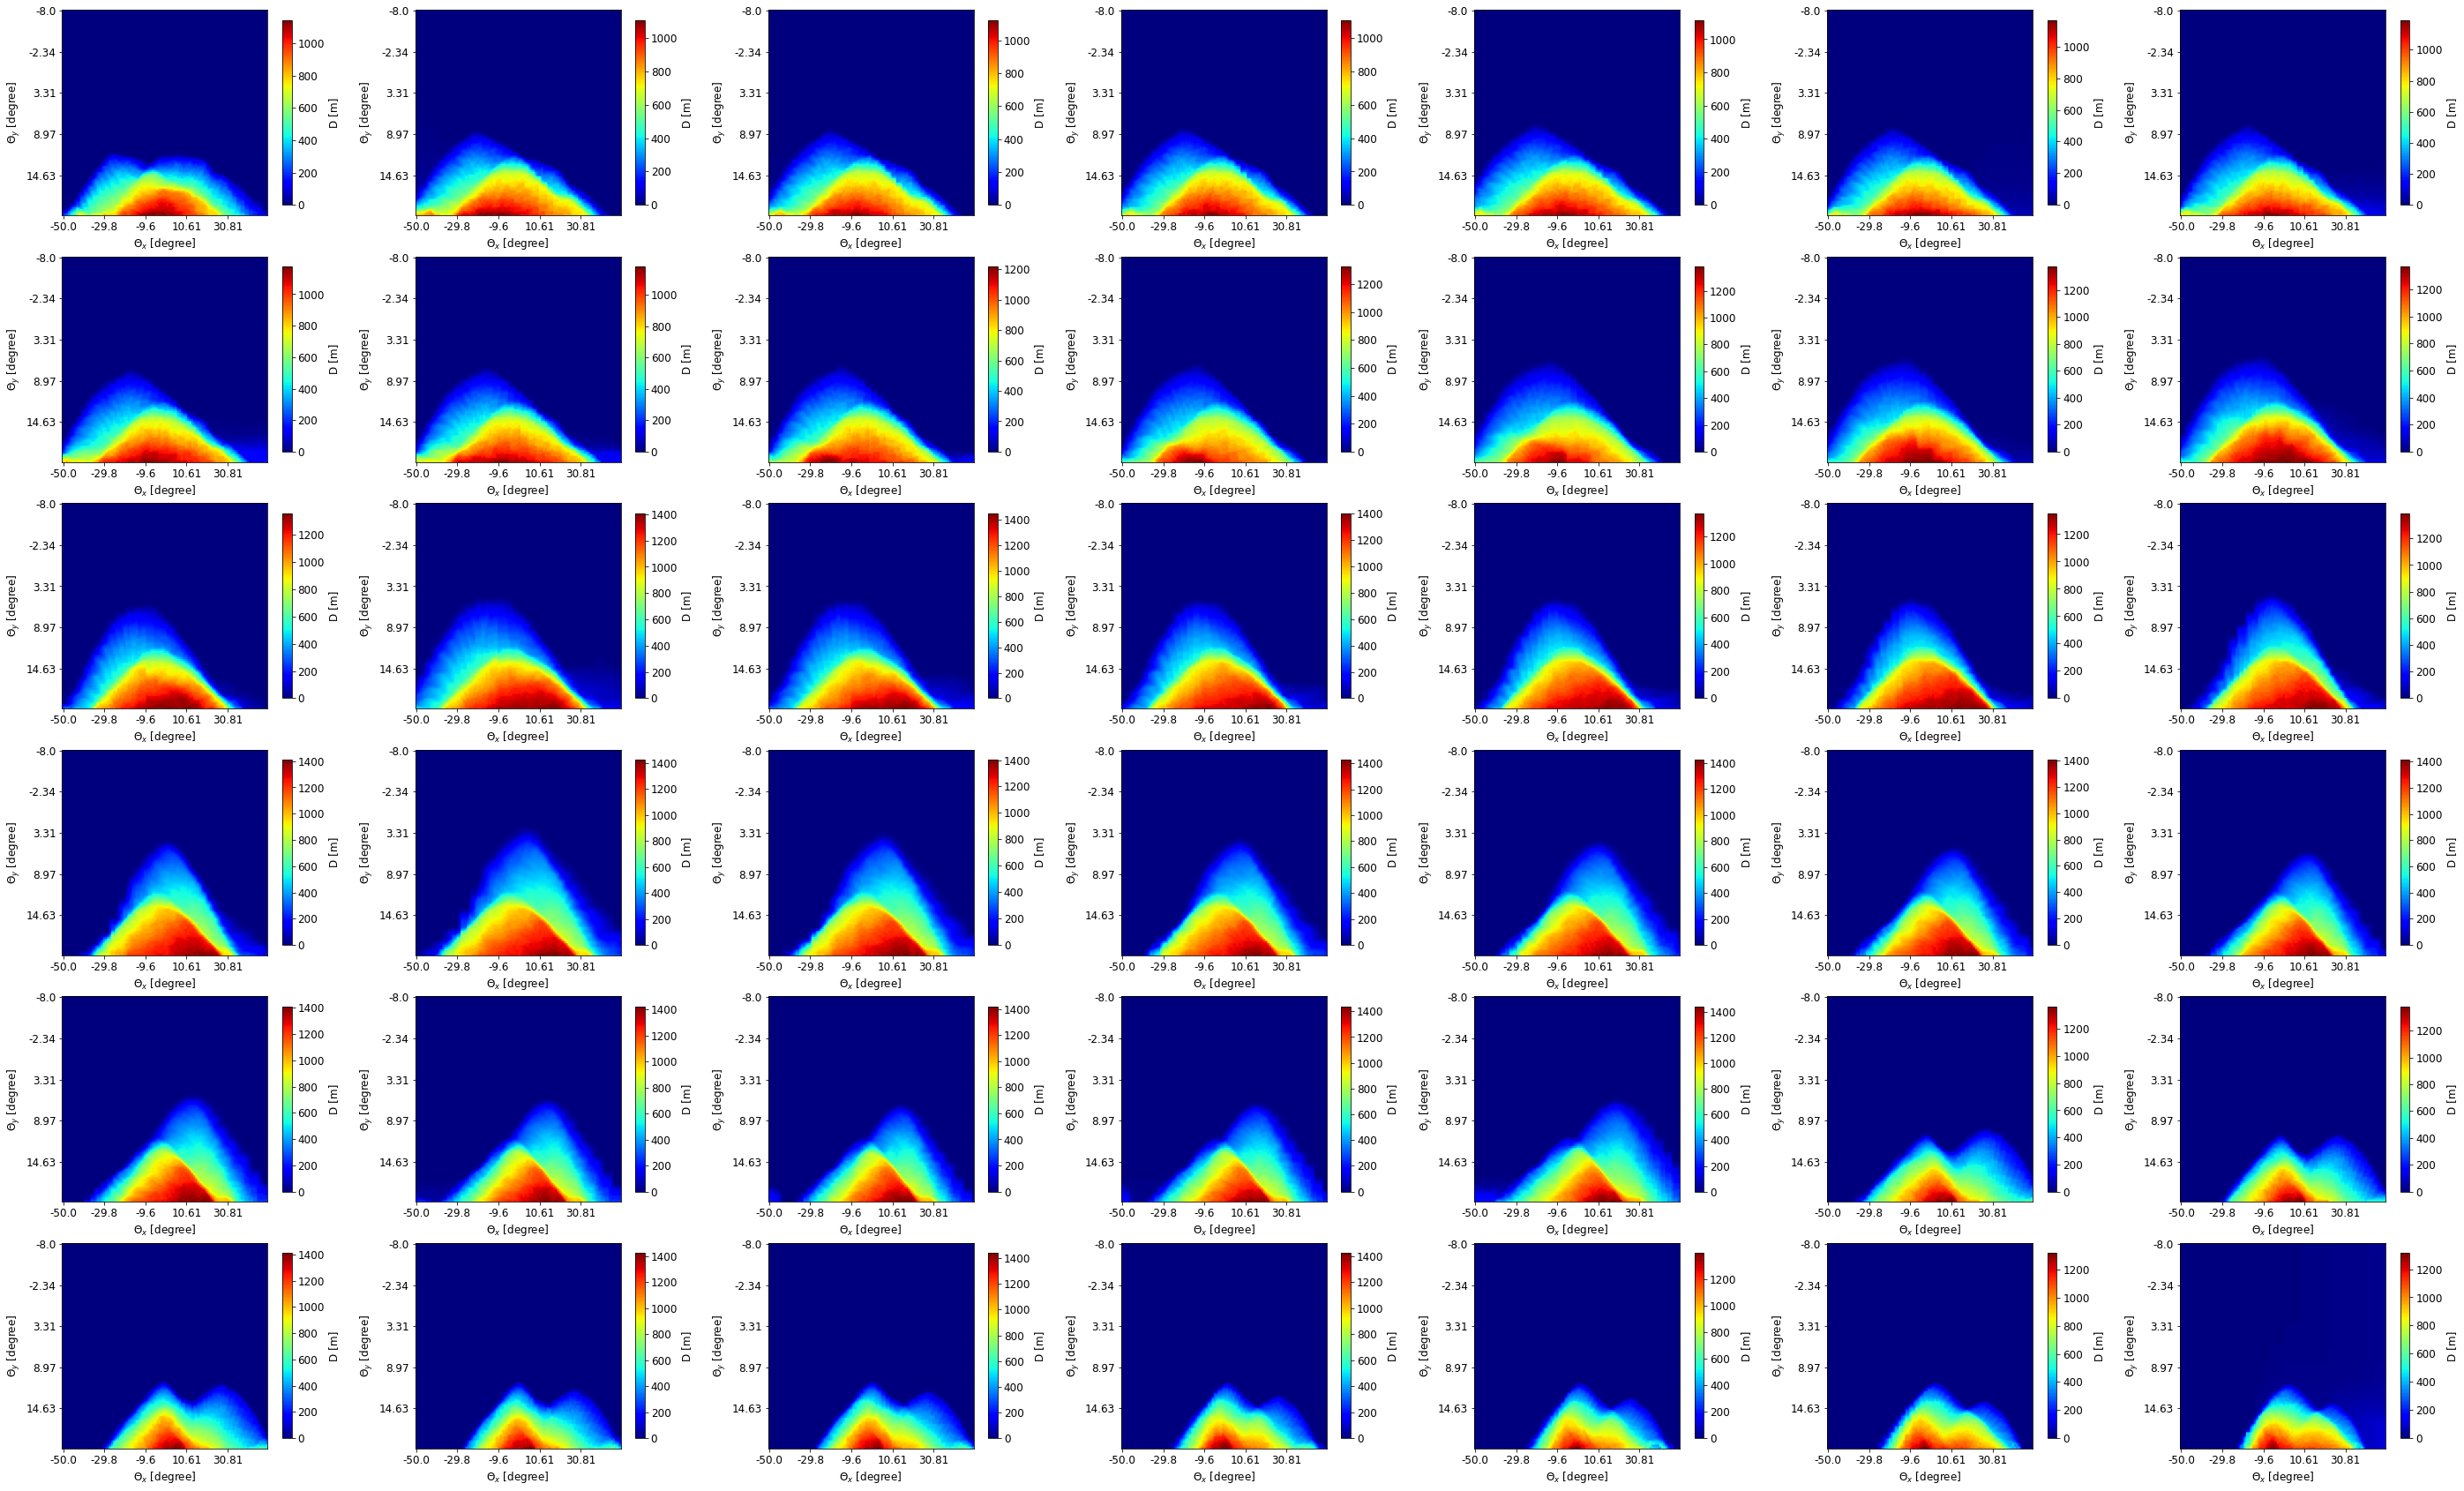

In [6]:
plot_muograms(data,cenit,azimut,data_list,6,7)

## Coordinates

In [7]:
def get_coords(path):
    return np.loadtxt(path)

In [8]:
points = get_coords('/home/kevin/coordinates5.dat')
print(points.shape)

(42, 2)


In [9]:
points2 = np.insert(points,0,np.array([[4.48666667,-75.38878788]]),axis=0)

In [10]:
def plot_detector_coords(coords,data_names,show_names=True,save=False,axis=True,heightmap=False):
    if heightmap:
        axis = False
        # Normalization to fit in heightmap
        coords[:,0] = (coords[:,0] - 4.5) / (4.47 - 4.5)*100
        coords[:,1] = (coords[:,1] - (-75.4)) / ((-75.37) - (-75.4))*100
    colors = np.ones(len(coords))+1
    colors[0] = 0 # Reference point
    colors = colors.astype('int32')
    colormap = np.array(['r','g','b'])
    plt.figure(figsize=(10,10))
    plt.scatter(coords[:,1],coords[:,0],c=colormap[colors])
    if show_names:
        for i in range(coords.shape[0]-1):
            plt.text(coords[i+1,1],coords[i+1,0],data_names[i],fontsize=8)
    plt.xlabel('long')
    plt.ylabel('lat')
    plt.title('Observation point positions')
    if axis:
        plt.axis([-75.4, -75.37, 4.47, 4.5])
    if save:
        plt.savefig('CMcoords.svg',format='svg')

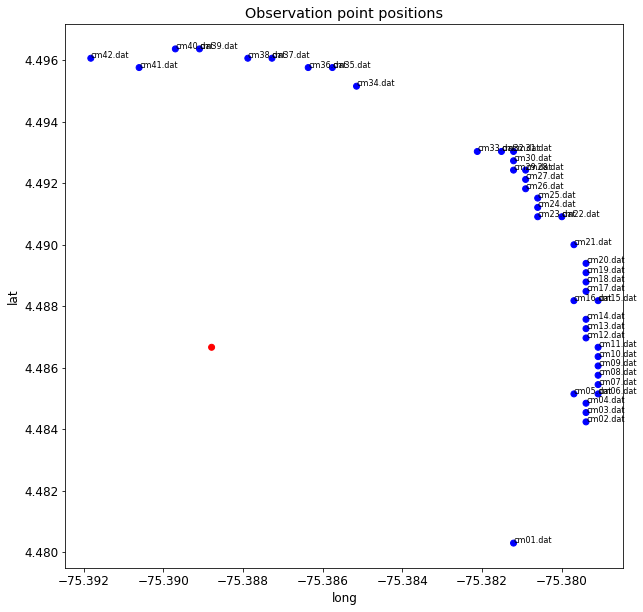

In [11]:
plot_detector_coords(points2,data_list,axis=False)

<Figure size 720x720 with 0 Axes>

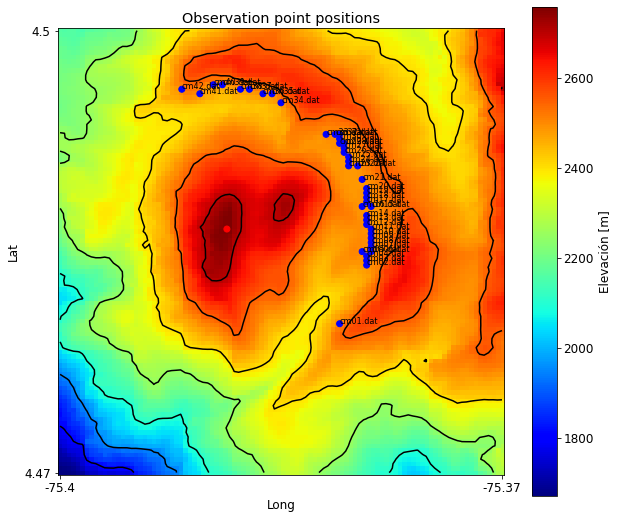

In [12]:
heightmap = np.loadtxt('/home/kevin/heightmap.dat')
#heightmap = (heightmap - np.min(heightmap)) / (np.max(heightmap) - np.min(heightmap)) # Normalization
plt.figure(figsize=(10,10))
plot_detector_coords(points2,data_list,heightmap=True)
plt.imshow(heightmap,cmap='jet')
plt.yticks([0,100-1],np.linspace(4.5,4.47,2))
plt.ylabel('Lat')
plt.xticks([0,100-1],np.linspace(-75.4,-75.37,2))
plt.xlabel('Long')
plt.colorbar(shrink=0.9,label='Elevación [m]')
plt.contour(heightmap,colors='k')
#plt.savefig('heightmap3.svg',format='svg')

### angles

In [13]:
def get_angles(points):
    return np.array([np.arctan2((point - points[0])[0],(point - points[0])[1])+(np.pi/2) for point in points[1:]])

In [14]:
angles = -get_angles(points2)
print(angles.shape,angles*180/np.pi)

(42,) [-130.03026637 -104.47033653 -102.72440061 -100.95411005  -99.46231199
  -98.88065014  -97.12500908  -95.35581955  -93.5763307   -91.78990876
  -90.          -88.1523917   -86.30861793  -84.4724657   -81.11934986
  -80.53768801  -79.04594874  -77.27565742  -75.52972066  -73.81081007
  -69.86371694  -64.2306979   -62.59245318  -60.94542563  -59.34936276
  -56.82152165  -55.3048805   -53.8418492   -52.76520245  -51.34022864
  -49.96977798  -48.81411388  -46.33226278  -23.19856606  -18.43492992
  -14.93140149   -9.16233746   -5.5275343     1.78990876    5.35581955
   11.30992035   17.87867878]


### How tomopy place the points

In [15]:
def create_points(R,angles):
    return np.insert(np.array([R*np.cos(angles),R*np.sin(angles)]),0,np.array([0,0]),axis=1).T

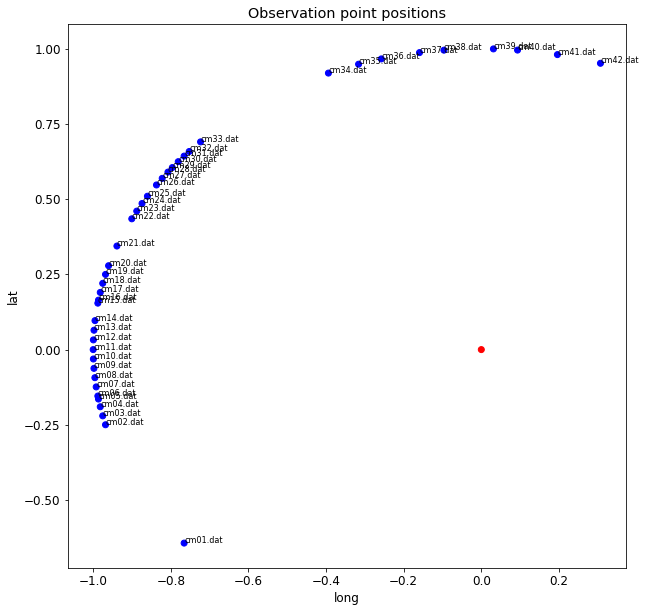

In [16]:
p = create_points(1,angles)
plot_detector_coords(p,data_list,axis=False)

## Reconstruction

In [17]:
import tomopy
rec = tomopy.recon(data,angles,algorithm='art')

In [18]:
rec.shape

(100, 100, 100)

In [19]:
recZ = np.sum(rec,axis=0)
recZ_norm = (recZ - np.min(recZ)) / (np.max(recZ) - np.min(recZ))

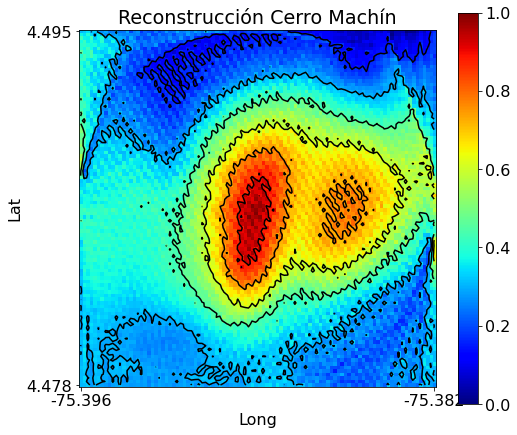

In [35]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8,8))
plt.imshow(recZ_norm,cmap='jet')
plt.title('Reconstrucción Cerro Machín')
plt.yticks([0,100-1],np.linspace(4.495,4.478,2))
plt.ylabel('Lat')
plt.xticks([0,100-1],np.linspace(-75.396,-75.382,2))
plt.xlabel('Long')
plt.colorbar(shrink=0.9)
plt.contour(recZ_norm,colors='k')
#plt.savefig('recCM.svg',format='svg')

### Error estimation

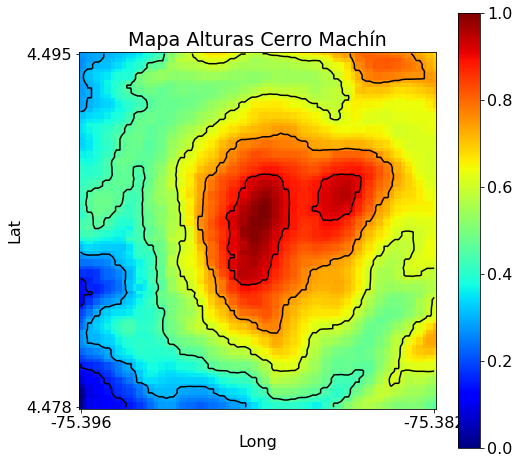

In [36]:
heightmap2 = np.loadtxt('/home/kevin/heightmap2.dat')
heightmap2 = (heightmap2 - np.min(heightmap2)) / (np.max(heightmap2) - np.min(heightmap2))
plt.figure(figsize=(8,8))
#plot_detector_coords(points,data_list,show_names=False,heightmap=True)
#plot_detector_coords(p,data_list,show_names=False,axis=False)
plt.imshow(heightmap2,cmap='jet')
plt.title('Mapa Alturas Cerro Machín')
plt.yticks([0,100-1],np.linspace(4.495,4.478,2))
plt.ylabel('Lat')
plt.xticks([0,100-1],np.linspace(-75.396,-75.382,2))
plt.xlabel('Long')
plt.colorbar()
plt.contour(heightmap2,colors='k')
#plt.savefig('heightmap3.svg',format='svg')

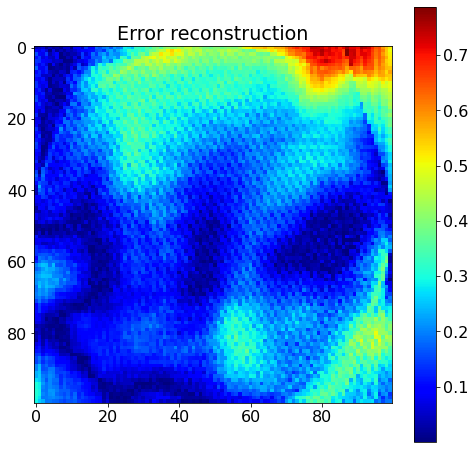

In [37]:
plt.figure(figsize=(8,8))
plt.imshow(abs(recZ_norm-heightmap2),cmap='jet')
plt.title('Error reconstruction')
plt.colorbar()
#plt.savefig('RecError.svg',format='svg')

## Number of points, angle and algorithm variation for Shepp-Logan reconstruction

### Angle variation for 42 points

In [24]:
obj = tomopy.shepp3d()

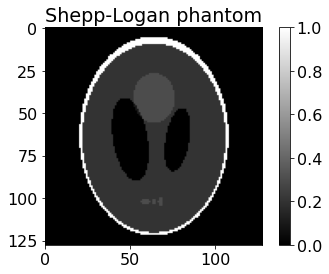

In [25]:
plt.imshow(obj[64],cmap='gray')
plt.title('Shepp-Logan phantom')
plt.colorbar()
#plt.savefig('shepp3d.svg',format='svg')

In [26]:
recs = []
for x in [np.pi,np.pi/2,np.pi/4]:
    ang = np.linspace(0,x,42)
    sim = tomopy.project(obj,ang)
    recs.append(tomopy.recon(sim,ang,algorithm='art'))
recs.append(tomopy.recon(tomopy.project(obj,angles),angles,algorithm='art'))

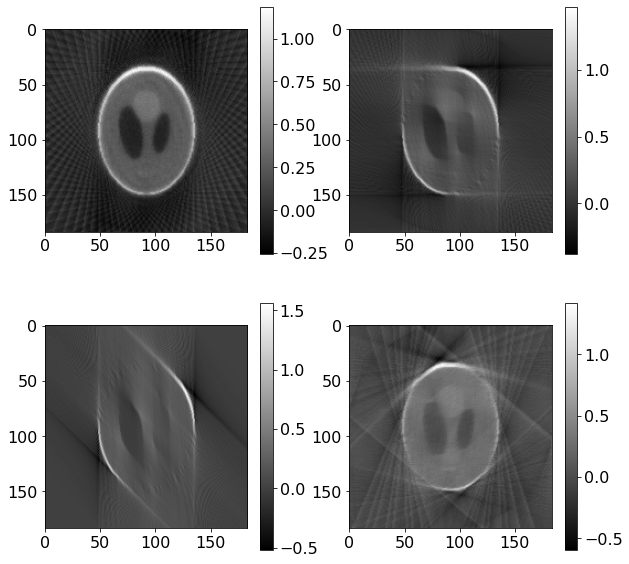

In [27]:
plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(recs[i][64],cmap='gray')
    plt.colorbar()
#plt.savefig('shepps.svg',format='svg')

### Number of points variation for 45 degree angle

In [28]:
recs2 = []
for x in [10,40,90,180]:
    ang = np.linspace(0,np.pi/4,x)
    sim = tomopy.project(obj,ang)
    recs2.append(tomopy.recon(sim,ang,algorithm='art'))

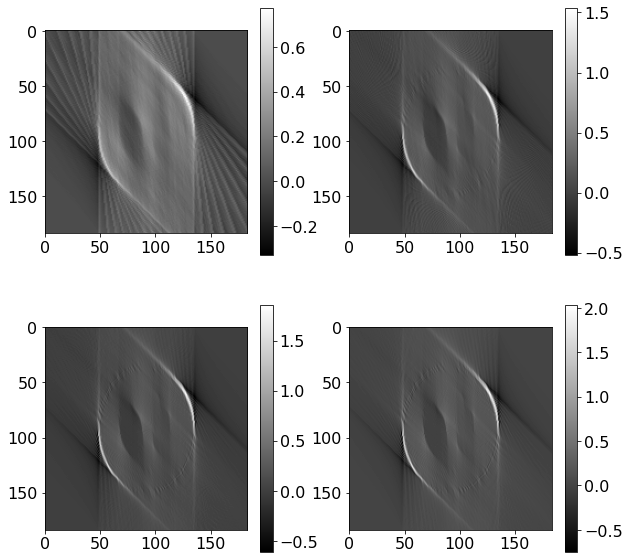

In [30]:
plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(recs2[i][64],cmap='gray')
    plt.colorbar()
#plt.savefig('shepps2.svg',format='svg')